# Network Algorithms

By the end, you should be able to:
- run and interpret **BFS** and **DFS** traversals,
- compute **shortest paths** in unweighted and weighted graphs,
- compute a **max-flow / min-cut** and interpret it as a bottleneck.

## Algorithms covered
- **BFS**: reachability, layers, and distances in **unweighted** graphs
- **DFS**: exploration, traversal order, and structure discovery
- **Shortest paths**:
  - BFS-based shortest paths (unweighted),
  - **Dijkstra** (weighted, nonnegative weights),
  - **Floyd–Warshall** (all-pairs shortest paths)
- **Max-Flow / Min-Cut**: flow under capacity constraints and bottleneck cuts

## Reproducibility
We fix random seeds so you should see the *same* graph structure and outputs every run.


In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

# Make plots look consistent
plt.rcParams["figure.figsize"] = (7, 6)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

def draw_graph(
    G,
    title="",
    pos=None,
    node_size=90,
    with_labels=False,
    edge_width=0.8,
    arrowsize=12,
):
    """
    Draw a graph with a consistent layout.
    Automatically handles directed vs undirected graphs.
    """
    if pos is None:
        pos = nx.spring_layout(G, seed=SEED)

    plt.figure()

    draw_kwargs = dict(
        node_size=node_size,
        with_labels=with_labels,
        width=edge_width,
    )

    if G.is_directed():
        draw_kwargs["arrows"] = True
        draw_kwargs["arrowsize"] = arrowsize
    else:
        draw_kwargs["arrows"] = False

    nx.draw(G, pos=pos, **draw_kwargs)

    plt.title(title)
    plt.axis("off")
    return pos


## 1. Generate a power-law graph with 100 nodes

We begin by generating a network with a **power-law degree distribution** using the
**preferential-attachment model** covered in class. In this model, nodes are added one-by-one and new edges attach to existing nodes following a probabilistic rule that promotes connection with existing nodes of high degree.

### Why this model?
- New nodes attach preferentially to well-connected nodes (rich-gets-richer effect).
- This produces a **heavy-tailed (power-law–like) degree distribution**.

### Parameters
- `n`: total number of nodes.
- `m_attach`: number of edges each new node adds when joining the network.
  - Small `m_attach` → sparse network.
  - Larger `m_attach` → denser network.

In this notebook we use `n = 100`, which is:
- large enough to show nontrivial structure,
- small enough to visualize and experiment with interactively.


Preferential-Attachment graph parameters:
  Number of nodes (n): 100
  Number of edges (m): 196
  Average degree: 3.92


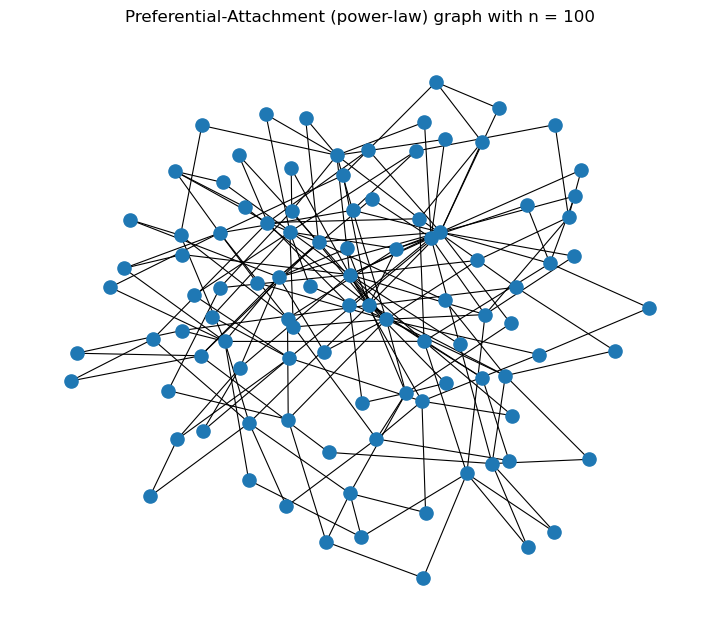

In [2]:
# ----------------------------
# Generate a scale-free graph
# ----------------------------
n = 100
m_attach = 2  # each new node attaches to m_attach existing nodes

# Preferential-Attachment model (undirected, unweighted)
G = nx.barabasi_albert_graph(n=n, m=m_attach, seed=SEED)

print(f"Preferential-Attachment graph parameters:")
print(f"  Number of nodes (n): {G.number_of_nodes()}")
print(f"  Number of edges (m): {G.number_of_edges()}")
print(f"  Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")

# Visualize the graph
# We store the layout positions so they can be reused later
pos = draw_graph(
    G,
    title="Preferential-Attachment (power-law) graph with n = 100",
    with_labels=False
)
plt.show()


## 1.5. Degree distribution (power-law flavor)

One hallmark of **heavy-tailed networks** is that most nodes have
**small degree**, while a few nodes (called *hubs*) have **very large degree**.

A common way to visualize this is with a **log–log plot** of the degree histogram:
- the x-axis shows the degree,
- the y-axis shows how many nodes have degree.

> Note: A straight line on a log–log plot suggests power-law–like behavior.


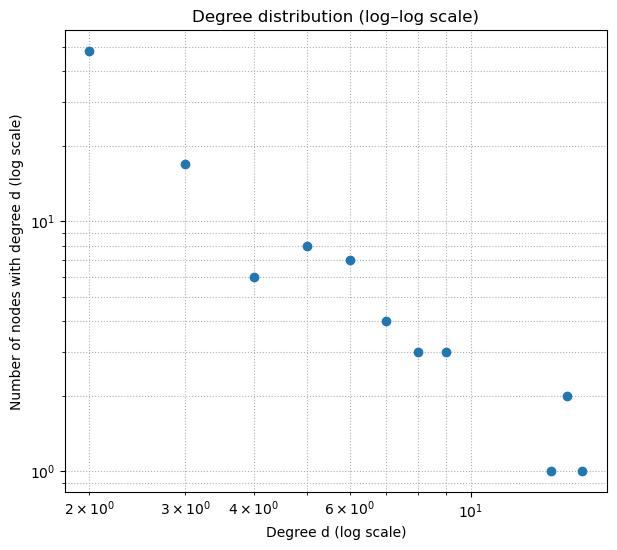

Degree statistics:
  Minimum degree: 2
  Maximum degree: 16
  Average degree: 3.92


In [3]:
# ----------------------------
# Degree distribution
# ----------------------------

# Extract node degrees
degrees = np.array([d for _, d in G.degree()])

# Histogram of degrees
unique_deg, counts = np.unique(degrees, return_counts=True)

# Log–log plot of the degree histogram
plt.figure()
plt.loglog(unique_deg, counts, marker='o', linestyle='None')
plt.xlabel("Degree d (log scale)")
plt.ylabel("Number of nodes with degree d (log scale)")
plt.title("Degree distribution (log–log scale)")
plt.grid(True, which="both", linestyle=":")
plt.show()

# Basic summary statistics
print("Degree statistics:")
print(f"  Minimum degree: {degrees.min()}")
print(f"  Maximum degree: {degrees.max()}")
print(f"  Average degree: {degrees.mean():.2f}")


## 2. Graph representations and conversions (LoE, AL, AM)

Many graph algorithms depend strongly on how a graph is stored in memory.
In network science, the three most common representations are:

- **List of edges (LoE)**: a list of pairs `(u, v)` representing edges.
- **Adjacency list (AL)**: for each node `u`, store the list of its neighbors.
- **Adjacency matrix (AM)**: an `n × n` matrix `A` where `A[u, v] = 1` if `(u, v)` is an edge.

### Why this matters
- BFS/DFS are fastest with an **adjacency list**.
- Matrix-based methods (e.g., some spectral computations) use an **adjacency matrix**.
- Many datasets are stored naturally as a **list of edges**.

### Goal of this section
We will construct all **six pairwise conversions** between these representations and verify
that they are consistent with one another.


Baseline representations:
  LoE length: 196
  AL total neighbor entries: 392  (should be 2m for undirected)
  AM shape: (100, 100)

Inspecting graph representations:

List of Edges (LoE) — first 10 edges:
  (0, 1)
  (0, 2)
  (0, 3)
  (0, 4)
  (0, 5)
  (0, 6)
  (0, 7)
  (0, 17)
  (0, 23)
  (0, 24)

Adjacency List (AL) — first 10 nodes:
  0: [1, 2, 3, 4, 5, 6, 7, 17, 23, 24, 34, 50, 56, 94, 99]
  1: [0, 3, 5, 7, 8, 9, 15, 21, 22, 35, 44, 57, 69, 78, 93, 97]
  2: [0, 10, 12, 14, 29, 62]
  3: [0, 1, 4, 6, 8, 9, 11, 13, 14, 25, 47, 59, 75, 98]
  4: [0, 3, 42]
  5: [0, 1, 11, 12, 13, 15, 18, 19, 48, 51, 60, 66, 81, 83, 86]
  6: [0, 3, 17, 18, 37, 42]
  7: [0, 1, 20, 22, 33, 37, 48, 62]
  8: [1, 3, 10, 26, 83, 87, 93]
  9: [1, 3, 32, 38, 77, 88]


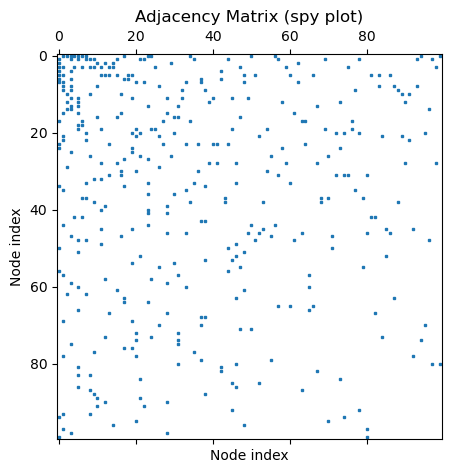


Size and storage space (undirected):
  n = 100, m = 196
  LoE stores ~ m pairs            -> O(m)
  AL stores ~ 2m neighbor entries -> O(n+m)
  AM stores n^2 entries           -> O(n^2)


In [4]:
# ----------------------------
# Graph representations and conversions (LoE, AL, AM)
# ----------------------------

n = G.number_of_nodes()

# 1) Build representations from NetworkX graph (baseline)
# LoE: list of edges (undirected => we store each edge once as (min, max) for consistency)
loe = [(min(u, v), max(u, v)) for (u, v) in G.edges()]
loe = sorted(set(loe))

# AL: adjacency list (dict: node -> sorted list of neighbors)
al = {u: sorted(list(G.neighbors(u))) for u in G.nodes()}

# AM: adjacency matrix (numpy array)
am = nx.to_numpy_array(G, nodelist=sorted(G.nodes()), dtype=int)

print("Baseline representations:")
print(f"  LoE length: {len(loe)}")
print(f"  AL total neighbor entries: {sum(len(v) for v in al.values())}  (should be 2m for undirected)")
print(f"  AM shape: {am.shape}")

# ----------------------------
# Conversion functions
# ----------------------------

def loe_to_al(loe, n):
    """LoE -> AL (undirected)."""
    al = {u: [] for u in range(n)}
    for u, v in loe:
        al[u].append(v)
        al[v].append(u)
    for u in al:
        al[u] = sorted(al[u])
    return al

def al_to_loe(al):
    """AL -> LoE (undirected, store each edge once)."""
    edges = set()
    for u, nbrs in al.items():
        for v in nbrs:
            a, b = (u, v) if u < v else (v, u)
            edges.add((a, b))
    return sorted(edges)

def loe_to_am(loe, n):
    """LoE -> AM (undirected)."""
    A = np.zeros((n, n), dtype=int)
    for u, v in loe:
        A[u, v] = 1
        A[v, u] = 1
    return A

def am_to_loe(A):
    """AM -> LoE (undirected, store each edge once)."""
    n = A.shape[0]
    edges = []
    for u in range(n):
        for v in range(u + 1, n):
            if A[u, v] != 0:
                edges.append((u, v))
    return edges

def al_to_am(al, n):
    """AL -> AM (undirected)."""
    A = np.zeros((n, n), dtype=int)
    for u, nbrs in al.items():
        for v in nbrs:
            A[u, v] = 1
            A[v, u] = 1
    return A

def am_to_al(A):
    """AM -> AL (undirected)."""
    n = A.shape[0]
    al = {u: [] for u in range(n)}
    for u in range(n):
        nbrs = list(np.where(A[u] != 0)[0])
        al[u] = sorted(nbrs)
    return al

# ----------------------------
# 6 pairwise conversions (back and forth)
# ----------------------------

# LoE <-> AL
al_from_loe = loe_to_al(loe, n)
loe_from_al = al_to_loe(al)

# LoE <-> AM
am_from_loe = loe_to_am(loe, n)
loe_from_am = am_to_loe(am)

# AL <-> AM
am_from_al = al_to_am(al, n)
al_from_am = am_to_al(am)


# ----------------------------
# Inspect the representations (small excerpts)
# ----------------------------

print("\nInspecting graph representations:")

# 1) List of edges (LoE): show a few entries
print("\nList of Edges (LoE) — first 10 edges:")
for e in loe[:10]:
    print(f"  {e}")

# 2) Adjacency list (AL): show a few nodes and their neighbors
print("\nAdjacency List (AL) — first 10 nodes:")
for u in range(10):
    print(f"  {u}: {al[u]}")

# 3) Adjacency matrix (AM): sparsity pattern
plt.figure(figsize=(5, 5))
plt.spy(am, markersize=2)
plt.title("Adjacency Matrix (spy plot)")
plt.xlabel("Node index")
plt.ylabel("Node index")
plt.show()

# ----------------------------
# Quick note on sizes (memory)
# ----------------------------
m = len(loe)
print("\nSize and storage space (undirected):")
print(f"  n = {n}, m = {m}")
print(f"  LoE stores ~ m pairs            -> O(m)")
print(f"  AL stores ~ 2m neighbor entries -> O(n+m)")
print(f"  AM stores n^2 entries           -> O(n^2)")


## 3. Breadth-First Search (BFS)

**Breadth-First Search (BFS)** explores a graph **layer-by-layer** starting from a chosen **source (seed) node** and continuing with nodes ordered by distance to the seed.

### What BFS computes
- The **distance** from the source to every reachable node (in an **unweighted** graph).
- A **BFS tree**: one particular set of edges that records how nodes were first discovered. A node that is distance $\ell+1$ from the seed is always discovered by a node that is distance $\ell$ from the seed, naturally inducing a tree structure.

### What to look for
- Nodes at distance 1 form the **first layer**, distance 2 the **second layer**, etc.
- The **layer sizes** tell you how quickly the exploration expands in the network.
- The **eccentricity** of the source is the largest distance from the source to any node.

### Complexity
Using an **adjacency list**, BFS runs in
$$
\mathcal{O}(n+m),
$$
where $n$ is the number of nodes and $m$ is the number of edges.


BFS from source 0: reached 100 nodes (connected: True)
Eccentricity of node 0 (max distance from source): 4

Layer sizes (distance -> number of nodes):
  0: 1
  1: 15
  2: 50
  3: 33
  4: 1


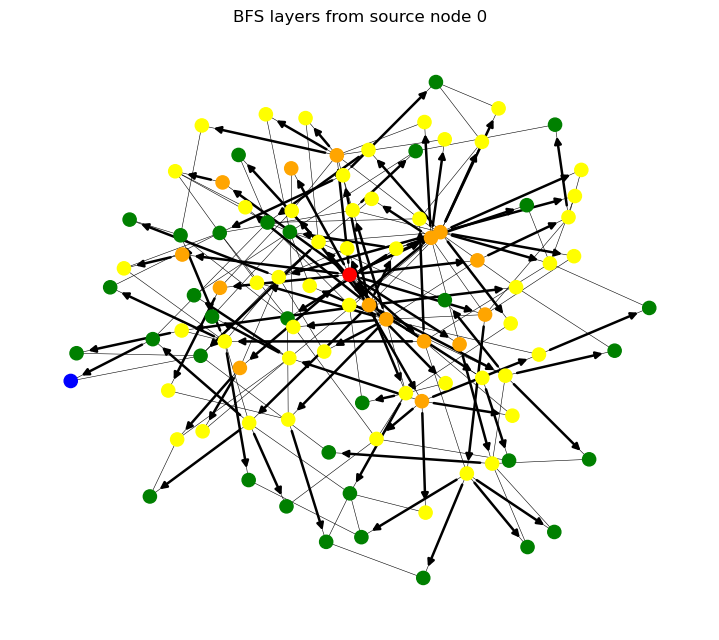

In [5]:
# ----------------------------
# Breadth-First Search (BFS) with distance-colored nodes
# ----------------------------
source = 0  # choose a seed node

# 1) Distances from the source (unweighted shortest-path distances)
dist = dict(nx.single_source_shortest_path_length(G, source))
ecc = max(dist.values())  # eccentricity of the source

is_connected = (len(dist) == G.number_of_nodes())
print(f"BFS from source {source}: reached {len(dist)} nodes (connected: {is_connected})")
print(f"Eccentricity of node {source} (max distance from source): {ecc}")

# 2) Layer sizes
layers = {}
for node, d in dist.items():
    layers.setdefault(d, []).append(node)

print("\nLayer sizes (distance -> number of nodes):")
for d in sorted(layers):
    print(f"  {d}: {len(layers[d])}")

# 3) Assign colors based on distance
def distance_to_color(d):
    if d == 0:
        return "red"
    elif d == 1:
        return "orange"
    elif d == 2:
        return "yellow"
    elif d == 3:
        return "green"
    else:
        return "blue"

node_colors = [distance_to_color(dist[node]) for node in G.nodes()]

# 4) BFS tree
T_bfs = nx.bfs_tree(G, source=source)

# 5) Visualization: color nodes by distance, overlay BFS tree edges
plt.figure()
nx.draw(
    G,
    pos=pos,
    node_size=90,
    node_color=node_colors,
    width=0.4,
)
nx.draw_networkx_edges(
    T_bfs,
    pos=pos,
    width=1.8,
)
plt.title(f"BFS layers from source node {source}")
plt.axis("off")
plt.show()


## 3.5. BFS visualization with concentric distance rings

In addition to the spring-layout visualization used above, we can make the
**layered structure of Breadth-First Search (BFS)** explicit by arranging
nodes in **concentric rings**.

### How to read the following plot
- The **source node** (in red) is placed at the **center**.
- Nodes at **distance 1** from the source lie on the **first circle**.
- Nodes at **distance 2** lie on the **second circle**, and so on.
- Each ring therefore corresponds to a **BFS layer**.

In the plot below:
- **Node colors encode distance** from the source (same color scheme as before).
- **BFS tree edges** are overlaid to show the actual discovery structure.

This visualization makes clear *why* BFS computes shortest paths in unweighted
graphs and how distance emerges as a geometric concept.


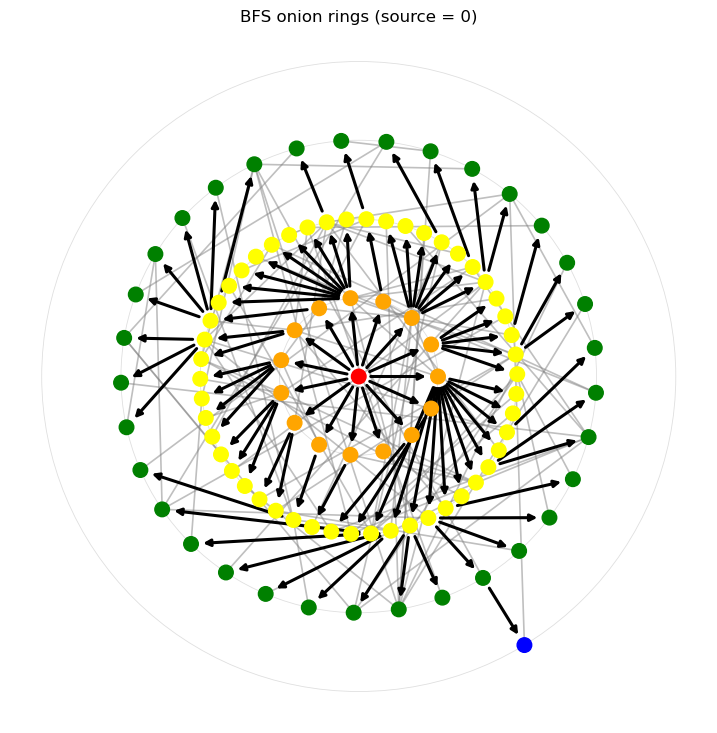

In [6]:
import math
from collections import defaultdict
import matplotlib.patches as patches

# ----------------------------
# BFS onion rings with parent-aligned rotation
# + visible (but subtle) non-tree edges
# ----------------------------
source = 0

# BFS tree and distances
T_bfs = nx.bfs_tree(G, source=source)
dist = dict(nx.single_source_shortest_path_length(G, source))

# ----------------------------
# 1) Group nodes by BFS distance
# ----------------------------
layers = defaultdict(list)
for v, d in dist.items():
    layers[d].append(v)
max_d = max(layers)

# Parent map from BFS tree
parent = {source: None}
for u, v in T_bfs.edges():
    parent[v] = u

# ----------------------------
# 2) Horizontal ordering (siblings stay together)
# ----------------------------
order = {0: [source]}
for d in range(1, max_d + 1):
    children_by_parent = defaultdict(list)
    for v in layers[d]:
        children_by_parent[parent[v]].append(v)
    for p in children_by_parent:
        children_by_parent[p] = sorted(children_by_parent[p])

    flat = []
    for p in order[d - 1]:
        flat.extend(children_by_parent.get(p, []))
    order[d] = flat

# ----------------------------
# 3) Onion positions with parent-aligned rotation
# ----------------------------
def angle_of(pos, v):
    x, y = pos[v]
    return math.atan2(y, x)

def circular_mean(angles):
    s = sum(math.sin(a) for a in angles)
    c = sum(math.cos(a) for a in angles)
    return math.atan2(s, c)

pos_onion = {source: (0.0, 0.0)}

for d in range(1, max_d + 1):
    nodes_d = order[d]
    k = len(nodes_d)
    if k == 0:
        continue

    base_angles = [2 * math.pi * idx / k for idx in range(k)]

    if d == 1:
        phi = 0.0
    else:
        target_angles = [angle_of(pos_onion, parent[v]) for v in nodes_d]
        diffs = [target_angles[i] - base_angles[i] for i in range(k)]
        phi = circular_mean(diffs)

    r = float(d)
    for idx, v in enumerate(nodes_d):
        theta = base_angles[idx] + phi
        pos_onion[v] = (r * math.cos(theta), r * math.sin(theta))

# ----------------------------
# 4) Color nodes by distance
# ----------------------------
def distance_to_color(d):
    if d == 0:
        return "red"
    elif d == 1:
        return "orange"
    elif d == 2:
        return "yellow"
    elif d == 3:
        return "green"
    else:
        return "blue"

node_colors = [distance_to_color(dist[v]) for v in G.nodes()]

# ----------------------------
# 5) Separate tree vs non-tree edges
# ----------------------------
tree_edges = list(T_bfs.edges())
tree_edge_set = set(tree_edges) | {(v, u) for u, v in tree_edges}

non_tree_edges = [
    (u, v) for (u, v) in G.edges()
    if (u, v) not in tree_edge_set and (v, u) not in tree_edge_set
]

# ----------------------------
# 6) Draw: rings + visible non-tree edges + thick tree edges
# ----------------------------
fig, ax = plt.subplots(figsize=(9, 9))

# Onion ring guides
for d in range(1, max_d + 1):
    ax.add_patch(
        patches.Circle(
            (0, 0),
            radius=d,
            fill=False,
            linewidth=0.6,
            alpha=0.25,
            edgecolor="gray"
        )
    )

# Non-tree edges: thin but visible
nx.draw_networkx_edges(
    G,
    pos=pos_onion,
    edgelist=non_tree_edges,
    width=1.2,        # increased from very thin
    alpha=0.5,       # increased so they are visible
    edge_color="gray",
    ax=ax
)

# Tree edges: thick and dominant
nx.draw_networkx_edges(
    T_bfs,
    pos=pos_onion,
    width=2.2,
    edge_color="black",
    ax=ax
)

# Nodes on top
nx.draw_networkx_nodes(
    G,
    pos=pos_onion,
    node_size=110,
    node_color=node_colors,
    ax=ax
)

ax.set_title(f"BFS onion rings (source = {source})")
ax.set_axis_off()
plt.show()


## 4. Depth-First Search (DFS)

**Depth-First Search (DFS)** explores a graph by going **as deep as possible** along one path,
and only then **backtracking** to try alternative branches.

### What DFS computes
- A **traversal order** (e.g., *preorder*): the order in which nodes are first discovered.
- A **DFS tree**: one particular spanning tree that records how nodes were discovered.

### What to look for
- DFS tends to produce **long, thin branches** before returning to explore other parts of the graph.
- The DFS tree depends on the **order in which neighbors are visited**.
  (To make results reproducible, we will visit neighbors in sorted order.)

### How to read the visualization below
The DFS tree is visualized using a layout designed to make the **dynamics of DFS explicit**:

- The **horizontal axis (x)** represents the **discovery time**
  (the order in which nodes are first visited by DFS).
- The **vertical axis (y)** represents the **recursion depth**
  (how deep DFS was in the call stack when the node was discovered).

As a result:
- Long downward chains correspond to **deep DFS dives**.
- Sudden upward jumps correspond to **backtracking**.
- Branching points show where DFS returns to explore alternative paths.

This visualization makes clear how DFS explores a network very differently from BFS:
DFS follows individual paths deeply before switching direction.

### Complexity
Using an **adjacency list**, DFS runs in
\[
\mathcal{O}(n+m).
\]


DFS preorder starting at 0 (first 20 nodes): [0, 1, 3, 4, 42, 6, 17, 27, 23, 13, 5, 11, 19, 20, 7, 22, 91, 10, 2, 12]
DFS visited 100 nodes (connected: True).
Maximum recursion depth reached: 46


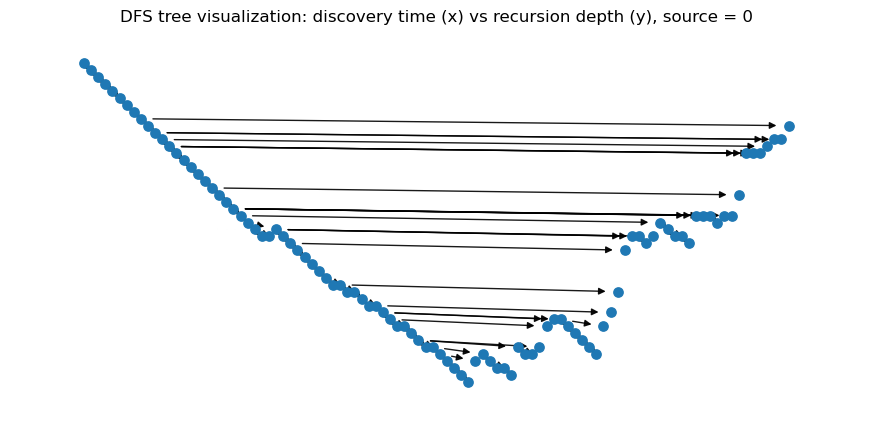

In [7]:
# ----------------------------
# Depth-First Search (DFS): discovery time vs recursion depth (Option 1)
# ----------------------------
source = 0  # seed node

# Deterministic neighbor order for reproducibility
def sorted_neighbors(G, u):
    return sorted(G.neighbors(u))

visited = set()
preorder = []         # discovery order
depth = {}            # node -> recursion depth at discovery
parent = {source: None}

def dfs(u, d):
    """Recursive DFS that records discovery order and recursion depth."""
    visited.add(u)
    preorder.append(u)
    depth[u] = d
    for v in sorted_neighbors(G, u):
        if v not in visited:
            parent[v] = u
            dfs(v, d + 1)

dfs(source, 0)

print(f"DFS preorder starting at {source} (first 20 nodes): {preorder[:20]}")
print(f"DFS visited {len(preorder)} nodes (connected: {len(preorder)==G.number_of_nodes()}).")
print(f"Maximum recursion depth reached: {max(depth.values())}")

# Build the DFS tree from parent pointers (matches our deterministic DFS)
T_dfs = nx.DiGraph()
T_dfs.add_nodes_from(preorder)
T_dfs.add_edges_from([(p, v) for v, p in parent.items() if p is not None])

# Positions: x = discovery time, y = recursion depth (negative to point downward)
xpos = {v: i for i, v in enumerate(preorder)}
pos_dfs = {v: (xpos[v], -depth[v]) for v in preorder}

plt.figure(figsize=(11, 5))

# Draw edges first
nx.draw_networkx_edges(T_dfs, pos=pos_dfs, width=1.0, alpha=0.9)

# Draw nodes
nx.draw_networkx_nodes(T_dfs, pos=pos_dfs, node_size=45)

plt.title(f"DFS tree visualization: discovery time (x) vs recursion depth (y), source = {source}")
plt.axis("off")
plt.show()


## 5. Shortest paths

Shortest-path algorithms quantify **how far apart nodes are** in a network and
identify **efficient routes** between them.

Depending on whether edges are weighted and on how many sources we care about,
different algorithms are appropriate.

### Unweighted shortest paths (BFS-based)
In **unweighted graphs**, shortest paths (minimum number of edges)
can be computed using **Breadth-First Search (BFS)**.

- Output: shortest-path distance from a source to all nodes,
  and a shortest path to any chosen target.
- Complexity: $\mathcal{O}(n+m)$.

### Weighted shortest paths (Dijkstra)
When edges have **nonnegative weights** (e.g., costs, delays),
**Dijkstra’s algorithm** computes shortest paths from a single source.

- Output: minimum total weight from the source to all nodes.
- Complexity: $\mathcal{O}(m \log n)$ for sparse graphs.

### All-pairs shortest paths (Floyd–Warshall)
If distances between **every pair of nodes** are required,
the **Floyd–Warshall algorithm** can be used.

- Output: a full distance matrix.
- Complexity: $\mathcal{O}(n^3)$.
- Practical only for small or medium-sized networks.

### What to look for
- BFS minimizes **number of hops**.
- Dijkstra minimizes **total weight**.
- Floyd–Warshall trades efficiency for **completeness** (all pairs).


In [8]:
# Pick a target node far from source for a more interesting path
source = 0
dist = dict(nx.single_source_shortest_path_length(G, source))
target = max(dist, key=dist.get)
print(f"Chose target = {target} with distance {dist[target]} from source {source}.")

# 5.1 BFS shortest path in unweighted graph
path_unweighted = nx.shortest_path(G, source=source, target=target)
print("Unweighted shortest path length:", len(path_unweighted)-1)
print("Path:", path_unweighted)

# Create a weighted version for Dijkstra (nonnegative weights)
Gw = G.copy()
for u, v in Gw.edges():
    Gw[u][v]["weight"] = int(np.random.randint(1, 11))  # weights 1..10

# 5.2 Dijkstra shortest path
dijkstra_len = nx.dijkstra_path_length(Gw, source=source, target=target, weight="weight")
dijkstra_path = nx.dijkstra_path(Gw, source=source, target=target, weight="weight")
print("\nDijkstra shortest path total weight:", dijkstra_len)
print("Dijkstra path:", dijkstra_path)

# 5.3 Floyd–Warshall all-pairs (on weighted graph)
D = nx.floyd_warshall_numpy(Gw, weight="weight")
print("\nFloyd–Warshall: distance matrix shape =", D.shape)
print("Distance(source,target) =", float(D[source, target]))


Chose target = 85 with distance 4 from source 0.
Unweighted shortest path length: 4
Path: [0, 1, 21, 52, 85]

Dijkstra shortest path total weight: 17
Dijkstra path: [0, 1, 21, 52, 85]

Floyd–Warshall: distance matrix shape = (100, 100)
Distance(source,target) = 17.0


## 6. Max-Flow / Min-Cut on a capacitated directed network

In this section we consider the **flow network** in the slide set **4.D. Network Flows and Cuts** to verify the results.
Each directed edge has a **capacity** (maximum amount that can pass through).

### What we compute
- A **maximum flow** value from a **source** $s$ to a **sink** $t$.
- A **minimum cut** $(S,T)$ separating $s$ and $t$ whose capacity equals the max flow
  (the **Max-Flow Min-Cut theorem**).

### Intuition
- **Max-flow** answers: *How much can we send from $s$ to $t$ without exceeding capacities?*
- **Min-cut** answers: *What is the smallest bottleneck that blocks all $s\to t$ routes?*
- The theorem says these two numbers are equal:
  the best possible transport is limited exactly by the tightest bottleneck.


Source s=0, sink t=5
Capacitated network: nodes=6, edges=10

Max-Flow / Min-Cut results:
  Max flow value: 23
  Min cut value:  23
  Max-Flow == Min-Cut? True
  Cut partition: S=[0, 1, 2, 4], T=[3, 5]


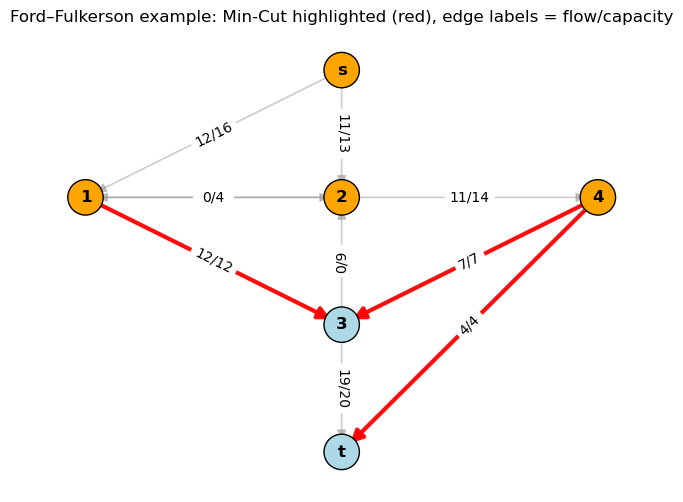

In [9]:
# ----------------------------
# Max-Flow / Min-Cut on the Ford–Fulkerson example network (fixed capacities)
# ----------------------------

import networkx as nx
import matplotlib.pyplot as plt

# 1) Build the capacitated directed network from the figure
FN = nx.DiGraph()
FN.add_nodes_from([0, 1, 2, 3, 4, 5])

# Capacities (from the attached diagram)
capacities = {
    (0, 1): 16,
    (0, 2): 13,
    (1, 2): 10,
    (2, 1): 4,
    (1, 3): 12,
    (3, 2): 9,
    (2, 4): 14,
    (4, 3): 7,
    (3, 5): 20,
    (4, 5): 4,
}

for (u, v), cap in capacities.items():
    FN.add_edge(u, v, capacity=cap)

s, t = 0, 5
print(f"Source s={s}, sink t={t}")
print(f"Capacitated network: nodes={FN.number_of_nodes()}, edges={FN.number_of_edges()}")

# 2) Max-flow (Edmonds–Karp) and Min-cut
flow_value, flow_dict = nx.maximum_flow(
    FN, s, t, capacity="capacity", flow_func=nx.algorithms.flow.edmonds_karp
)
cut_value, (S, T) = nx.minimum_cut(FN, s, t, capacity="capacity")

print("\nMax-Flow / Min-Cut results:")
print(f"  Max flow value: {flow_value}")
print(f"  Min cut value:  {cut_value}")
print(f"  Max-Flow == Min-Cut? {flow_value == cut_value}")
print(f"  Cut partition: S={sorted(list(S))}, T={sorted(list(T))}")

# 3) Orderly layered visualization (s at top, S above T, t at bottom)
def layered_cut_layout(H, S_set, T_set, s, t, y_gap=1.8, x_gap=1.2, passes=4):
    r"""
    Create a clean layered layout for a cut (S,T):
      Layer 0: {s}
      Layer 1: S \ {s}
      Layer 2: T \ {t}
      Layer 3: {t}

    Within each layer, order nodes to reduce crossings using simple barycentric passes.
    """
    layer0 = [s] if s in H else []
    layer3 = [t] if t in H else []
    layer1 = sorted([v for v in H.nodes() if (v in S_set and v != s)])
    layer2 = sorted([v for v in H.nodes() if (v in T_set and v != t)])
    layers = [layer0, layer1, layer2, layer3]

    U = H.to_undirected()
    order = {i: list(layers[i]) for i in range(4)}

    def barycentric_sort(layer_idx, ref_idx):
        ref = order[ref_idx]
        if len(ref) == 0 or len(order[layer_idx]) == 0:
            return
        ref_pos = {v: j for j, v in enumerate(ref)}

        def score(v):
            neigh = [u for u in U.neighbors(v) if u in ref_pos]
            if not neigh:
                return float("inf")
            return sum(ref_pos[u] for u in neigh) / len(neigh)

        order[layer_idx].sort(key=score)

    for _ in range(passes):
        barycentric_sort(1, 0)
        barycentric_sort(2, 1)
        barycentric_sort(3, 2)
        barycentric_sort(2, 3)
        barycentric_sort(1, 2)
        barycentric_sort(0, 1)

    pos = {}
    for li in range(4):
        nodes = order[li]
        k = len(nodes)
        if k == 0:
            continue
        x0 = -(k - 1) / 2.0
        for j, v in enumerate(nodes):
            pos[v] = ((x0 + j) * x_gap, -li * y_gap)

    return pos, order

H = FN  # full graph is small, so we plot it entirely

node_colors = ["orange" if v in S else "lightblue" for v in H.nodes()]

# Cut edges (S -> T) inside H
cut_edges = [(u, v) for (u, v) in H.edges() if (u in S and v in T)]
other_edges = [(u, v) for (u, v) in H.edges() if (u, v) not in cut_edges]

pos_h, _ = layered_cut_layout(H, S, T, s, t, y_gap=1.9, x_gap=1.4, passes=6)

plt.figure(figsize=(8, 6))

# Non-cut edges: thin + faint
nx.draw_networkx_edges(
    H, pos=pos_h, edgelist=other_edges,
    width=1.2, alpha=0.4, edge_color="gray",
    arrows=True, arrowsize=14
)

# Cut edges: thick + red
nx.draw_networkx_edges(
    H, pos=pos_h, edgelist=cut_edges,
    width=3.0, alpha=0.95, edge_color="red",
    arrows=True, arrowsize=18
)

# Nodes
nx.draw_networkx_nodes(H, pos=pos_h, node_size=650, node_color=node_colors, edgecolors="black")

# Labels for nodes (show node id; highlight s and t as 's'/'t')
labels = {v: str(v) for v in H.nodes()}
labels[s] = "s"
labels[t] = "t"
nx.draw_networkx_labels(H, pos=pos_h, labels=labels, font_size=12, font_weight="bold")

# Edge labels: show capacity, and (flow/capacity) in one label for clarity
edge_labels = {}
for u, v in H.edges():
    cap = H[u][v]["capacity"]
    fuv = flow_dict[u].get(v, 0)
    edge_labels[(u, v)] = f"{fuv}/{cap}"

nx.draw_networkx_edge_labels(H, pos=pos_h, edge_labels=edge_labels, font_size=10)

plt.title("Ford–Fulkerson example: Min-Cut highlighted (red), edge labels = flow/capacity")
plt.axis("off")
plt.show()


## Wrap-up: A network algorithms toolbox

You have now seen a compact **algorithmic toolbox** for analyzing complex networks.

### What each algorithm answers
- **BFS / DFS**
  Answer *reachability and exploration* questions:
  - Which nodes can be reached from a given seed?
  - How does information or influence spread through the network?
  - BFS reveals layered structure; DFS reveals deep exploration paths.

- **Shortest paths**
  Answer *distance and efficiency* questions:
  - What is the minimum number of steps between nodes (BFS)?
  - What is the minimum total cost when edges have weights (Dijkstra)?
  - How far apart are all pairs of nodes (Floyd–Warshall)?

- **Max-flow / min-cut**
  Answer *capacity and robustness* questions:
  - How much can be transported from a source to a sink?
  - What are the bottlenecks that limit throughput?
  - Which edges or nodes are critical for network performance?

### Key ideas to remember
- Different algorithms answer **different network questions**.
- The **choice of graph representation** (edge list, adjacency list, adjacency matrix)
  strongly affects computational cost.
- Many real-world networks are **sparse**, enabling near-linear-time algorithms.
- Global network behavior often emerges from **simple local rules**.

In later sections, these same tools will reappear as building blocks for
more advanced network-science methods.
